# Traffic Signal Timing Recommendation Analysis

This notebook visualizes the results from the ML-based traffic signal timing optimization model for Highway 102 in Bentonville.

## Overview
- Load recommendation data from NDJSON output files
- Compare before/after delay and Level of Service (LOS)
- Visualize improvements by intersection and time period
- Analyze phase timing changes

## 1. Import Required Libraries

In [3]:
import json
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Recommendation Data

Load all recommendation files from the output directory. Each file contains timing recommendations for a specific intersection.

In [4]:
def load_recommendations(output_dir='output'):
    """Load all recommendation NDJSON files from the output directory."""
    recommendations = []
    
    ndjson_files = glob.glob(os.path.join(output_dir, '*_recommendations.ndjson'))
    
    for filepath in ndjson_files:
        with open(filepath, 'r') as f:
            for line in f:
                if line.strip():
                    rec = json.loads(line)
                    recommendations.append(rec)
    
    return pd.DataFrame(recommendations)

# Load the data
df = load_recommendations('output')
print(f"Loaded {len(df)} recommendations from {df['intersection_id'].nunique()} intersections")
df.head()

Loaded 20 recommendations from 10 intersections


,intersection_id,timestamp,time_window,cycle_length_recommended,phases,recommended_change_score,notes,is_valid,los_before,los_after,delay_before,delay_after,phase_plan,period_name,intervals_in_period
0,102_Walton,2025-12-02T09:16:48.431615,13:15-14:45,170.0,"[{'phase': '1NBLT', 'green_recommended': 15.0,...",64.3,"[Estimated delay reduction: 14.3%, LOS improve...",True,F,F,102.1,87.6,61,early_afternoon,174
1,102_Walton,2025-12-02T09:16:48.611238,14:45-18:45,170.0,"[{'phase': '1NBLT', 'green_recommended': 15.0,...",64.0,"[Estimated delay reduction: 14.0%, LOS improve...",True,F,F,96.7,83.2,64,pm_peak,464
2,102_Moberly,2025-12-02T09:16:47.915185,13:15-14:45,180.0,"[{'phase': '1WBLT', 'green_recommended': 15.0,...",100.0,"[Estimated delay reduction: 50.6%, LOS improve...",True,F,D,87.4,43.2,61,early_afternoon,174
3,102_Moberly,2025-12-02T09:16:48.095218,14:45-18:45,180.0,"[{'phase': '1WBLT', 'green_recommended': 15.0,...",100.0,"[Estimated delay reduction: 53.6%, LOS improve...",True,F,D,90.2,41.9,64,pm_peak,464
4,102_P,2025-12-02T09:16:48.238405,13:15-14:45,60.0,"[{'phase': '1EBLT', 'green_recommended': 15.0,...",100.0,"[Estimated delay reduction: 96.0%, LOS improve...",True,F,A,96.8,3.9,61,early_afternoon,174


In [5]:
# Calculate improvement metrics
df['delay_improvement'] = df['delay_before'] - df['delay_after']
df['delay_improvement_pct'] = (df['delay_improvement'] / df['delay_before'] * 100).round(1)
df['los_improved'] = df['los_before'] != df['los_after']

# Convert LOS to numeric for analysis (A=1, F=6)
los_to_num = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
df['los_before_num'] = df['los_before'].map(los_to_num)
df['los_after_num'] = df['los_after'].map(los_to_num)
df['los_change'] = df['los_before_num'] - df['los_after_num']

print("Data summary:")
print(f"  Total recommendations: {len(df)}")
print(f"  Intersections: {df['intersection_id'].nunique()}")
print(f"  Time periods: {df['time_window'].unique().tolist()}")
print(f"  Phase plans used: {df['phase_plan'].unique().tolist() if 'phase_plan' in df.columns else 'N/A'}")

Data summary:
  Total recommendations: 20
  Intersections: 10
  Time periods: ['13:15-14:45', '14:45-18:45']
  Phase plans used: [61, 64]


## 3. Summary Statistics

Overview of delay improvements and LOS changes across all intersections.

In [6]:
# Create summary table
summary = df.groupby('intersection_id').agg({
    'delay_before': 'mean',
    'delay_after': 'mean',
    'delay_improvement': 'sum',
    'delay_improvement_pct': 'mean',
    'los_improved': 'sum'
}).round(1)

summary.columns = ['Avg Delay Before (s)', 'Avg Delay After (s)', 'Total Delay Saved (s)', 
                   'Avg Improvement (%)', 'Periods with LOS Improvement']
summary = summary.sort_values('Total Delay Saved (s)', ascending=False)

print("=== Intersection Summary (sorted by total delay saved) ===\n")
display(summary)

=== Intersection Summary (sorted by total delay saved) ===



,Avg Delay Before (s),Avg Delay After (s),Total Delay Saved (s),Avg Improvement (%),Periods with LOS Improvement
intersection_id,,,,,
102_A,91.0,37.1,107.8,49.7,1
102_C,84.6,35.4,98.3,53.2,1
102_P,77.6,31.2,92.9,48.0,1
102_Moberly,88.8,42.6,92.5,52.0,2
102_Greenhouse,124.8,103.2,43.2,17.2,0
102_Walton,99.4,85.4,28.0,14.1,0
102_I,81.2,69.0,24.3,14.4,1
102_Been,62.6,62.6,0.0,0.0,0
102_Elm,89.4,89.4,0.0,0.0,0


## 4. Delay Comparison Visualization

Compare before and after delays for each intersection and time period.

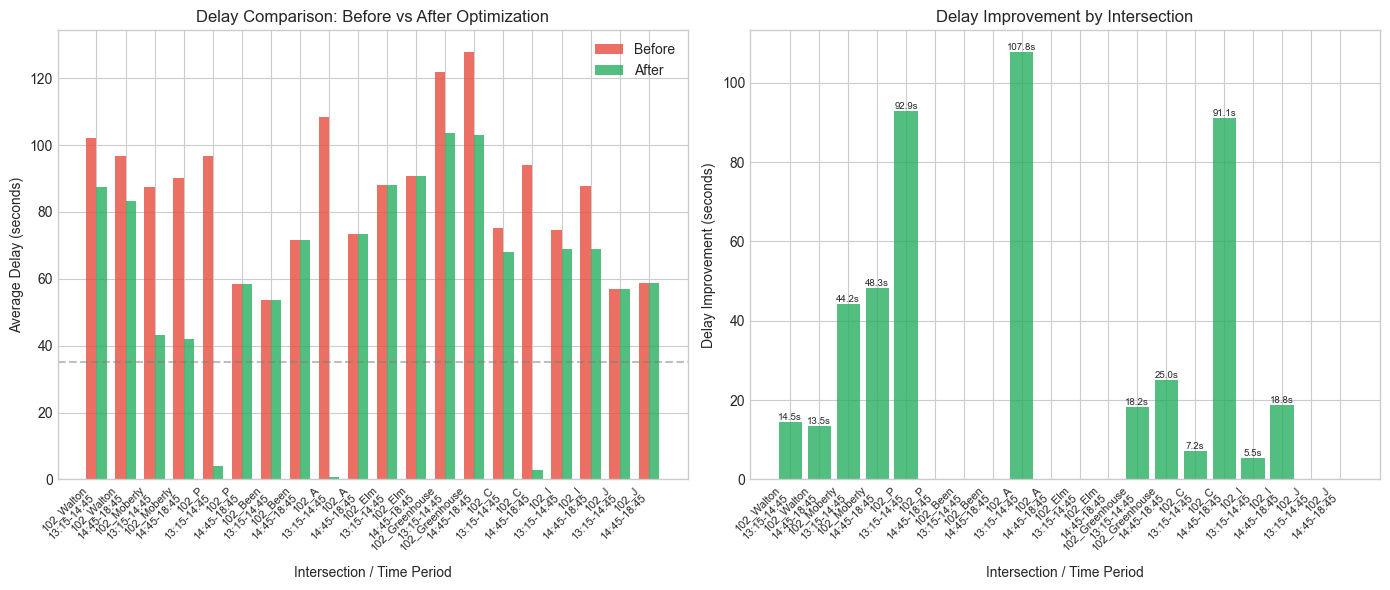

Saved: output/delay_comparison.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Before vs After Delay by Intersection
ax1 = axes[0]
x = np.arange(len(df))
width = 0.35

# Create labels combining intersection and time window
labels = [f"{row['intersection_id']}\n{row['time_window']}" for _, row in df.iterrows()]

bars1 = ax1.bar(x - width/2, df['delay_before'], width, label='Before', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x + width/2, df['delay_after'], width, label='After', color='#27ae60', alpha=0.8)

ax1.set_xlabel('Intersection / Time Period')
ax1.set_ylabel('Average Delay (seconds)')
ax1.set_title('Delay Comparison: Before vs After Optimization')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax1.legend()
ax1.axhline(y=35, color='gray', linestyle='--', alpha=0.5, label='LOS D threshold')

# Plot 2: Delay Improvement
ax2 = axes[1]
colors = ['#27ae60' if imp > 0 else '#e74c3c' for imp in df['delay_improvement']]
bars = ax2.bar(x, df['delay_improvement'], color=colors, alpha=0.8)
ax2.set_xlabel('Intersection / Time Period')
ax2.set_ylabel('Delay Improvement (seconds)')
ax2.set_title('Delay Improvement by Intersection')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels on bars
for bar, val in zip(bars, df['delay_improvement']):
    if val != 0:
        ax2.annotate(f'{val:.1f}s', 
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom' if val > 0 else 'top',
                    fontsize=7)

plt.tight_layout()
plt.savefig('output/delay_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: output/delay_comparison.png")

## 5. Level of Service (LOS) Analysis

Visualize LOS changes before and after optimization. LOS ranges from A (best) to F (worst).

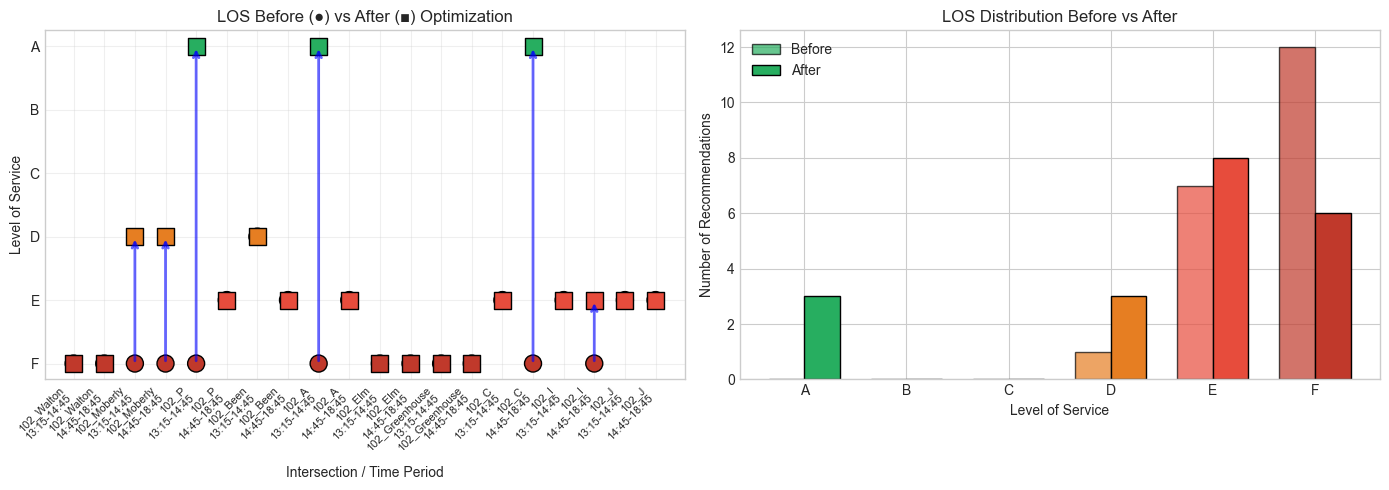

Saved: output/los_analysis.png


In [8]:
# LOS color mapping
los_colors = {'A': '#27ae60', 'B': '#2ecc71', 'C': '#f1c40f', 
              'D': '#e67e22', 'E': '#e74c3c', 'F': '#c0392b'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: LOS Before and After
ax1 = axes[0]
labels = [f"{row['intersection_id']}\n{row['time_window']}" for _, row in df.iterrows()]
x = np.arange(len(df))

# Create color lists
colors_before = [los_colors.get(los, 'gray') for los in df['los_before']]
colors_after = [los_colors.get(los, 'gray') for los in df['los_after']]

ax1.scatter(x, df['los_before_num'], c=colors_before, s=150, marker='o', label='Before', edgecolors='black', linewidth=1, zorder=3)
ax1.scatter(x, df['los_after_num'], c=colors_after, s=150, marker='s', label='After', edgecolors='black', linewidth=1, zorder=3)

# Draw arrows showing improvement
for i, row in df.iterrows():
    if row['los_before_num'] != row['los_after_num']:
        ax1.annotate('', xy=(i, row['los_after_num']), xytext=(i, row['los_before_num']),
                    arrowprops=dict(arrowstyle='->', color='blue', lw=2, alpha=0.6))

ax1.set_xlabel('Intersection / Time Period')
ax1.set_ylabel('Level of Service')
ax1.set_title('LOS Before (●) vs After (■) Optimization')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax1.set_yticks([1, 2, 3, 4, 5, 6])
ax1.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F'])
ax1.invert_yaxis()  # A at top, F at bottom
ax1.grid(True, alpha=0.3)

# Plot 2: LOS Distribution
ax2 = axes[1]
los_before_counts = df['los_before'].value_counts().reindex(['A', 'B', 'C', 'D', 'E', 'F'], fill_value=0)
los_after_counts = df['los_after'].value_counts().reindex(['A', 'B', 'C', 'D', 'E', 'F'], fill_value=0)

x_los = np.arange(6)
width = 0.35

bars1 = ax2.bar(x_los - width/2, los_before_counts.values, width, label='Before', 
                color=[los_colors[l] for l in los_before_counts.index], alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x_los + width/2, los_after_counts.values, width, label='After',
                color=[los_colors[l] for l in los_after_counts.index], alpha=1.0, edgecolor='black')

ax2.set_xlabel('Level of Service')
ax2.set_ylabel('Number of Recommendations')
ax2.set_title('LOS Distribution Before vs After')
ax2.set_xticks(x_los)
ax2.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F'])
ax2.legend()

plt.tight_layout()
plt.savefig('output/los_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: output/los_analysis.png")

## 6. Improvement Heatmap by Intersection and Time Period

Create a heatmap showing delay improvement across intersections and time periods.

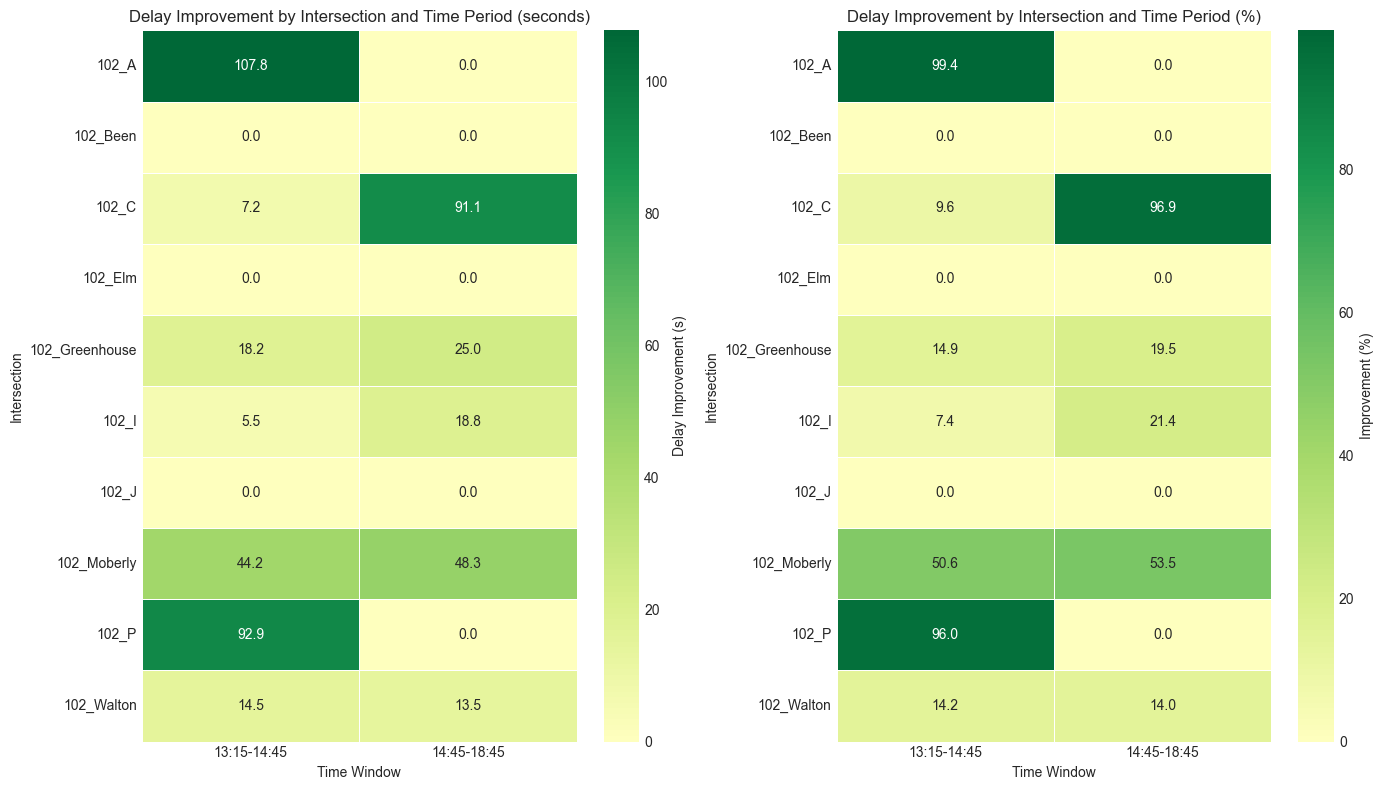

Saved: output/improvement_heatmap.png


In [9]:
# Pivot data for heatmap
pivot_delay = df.pivot(index='intersection_id', columns='time_window', values='delay_improvement')
pivot_pct = df.pivot(index='intersection_id', columns='time_window', values='delay_improvement_pct')

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Heatmap 1: Absolute delay improvement
ax1 = axes[0]
sns.heatmap(pivot_delay, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            linewidths=0.5, ax=ax1, cbar_kws={'label': 'Delay Improvement (s)'})
ax1.set_title('Delay Improvement by Intersection and Time Period (seconds)')
ax1.set_xlabel('Time Window')
ax1.set_ylabel('Intersection')

# Heatmap 2: Percentage improvement
ax2 = axes[1]
sns.heatmap(pivot_pct, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            linewidths=0.5, ax=ax2, cbar_kws={'label': 'Improvement (%)'})
ax2.set_title('Delay Improvement by Intersection and Time Period (%)')
ax2.set_xlabel('Time Window')
ax2.set_ylabel('Intersection')

plt.tight_layout()
plt.savefig('output/improvement_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: output/improvement_heatmap.png")

## 7. Phase Timing Changes

Visualize the recommended green time changes for each phase at select intersections.

NameError: name 'all_data' is not defined

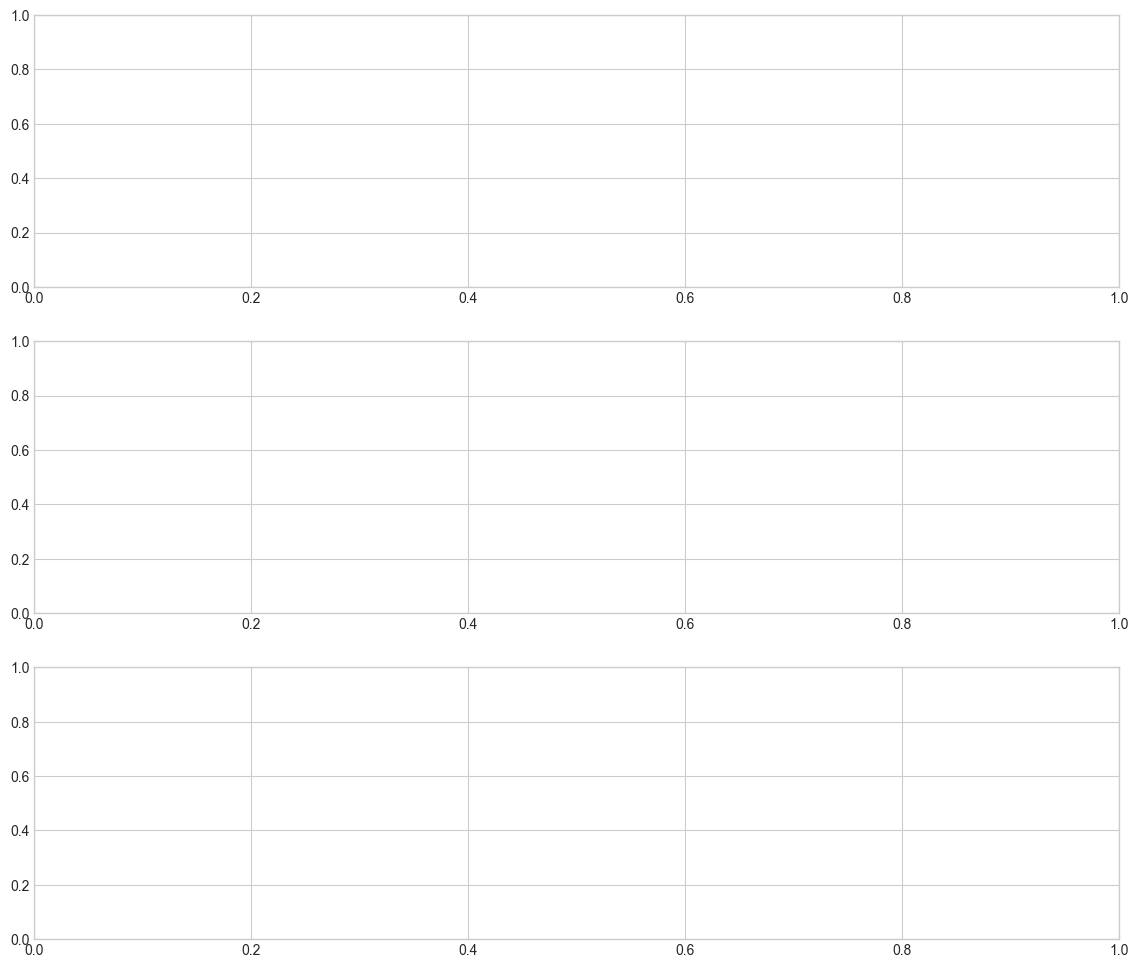

In [ ]:
# Select a few intersections to show timing changes
sample_intersections = ['102_A', '102_C', '102_P']

fig, axes = plt.subplots(len(sample_intersections), 1, figsize=(14, 4 * len(sample_intersections)))

for idx, intersection in enumerate(sample_intersections):
    ax = axes[idx] if len(sample_intersections) > 1 else axes
    
    # Get records for this intersection
    int_records = df[df['intersection_id'] == intersection].to_dict(orient='records')
    
    if not int_records:
        ax.text(0.5, 0.5, f'No data for {intersection}', ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Extract phase green times from current and recommended
    for rec in int_records[:2]:  # First two time periods
        current = rec.get('current_timing', {})
        recommended = rec.get('recommended_timing', {})
        
        if current and recommended:
            phases = []
            current_greens = []
            recommended_greens = []
            
            for phase_key in current.keys():
                if phase_key.startswith('phase_'):
                    phase_num = phase_key.split('_')[1]
                    phases.append(f'Phase {phase_num}')
                    current_greens.append(current[phase_key].get('green_time', 0))
                    recommended_greens.append(recommended[phase_key].get('green_time', 0))
            
            x = np.arange(len(phases))
            width = 0.35
            
            bars1 = ax.bar(x - width/2, current_greens, width, label=f'Current ({rec["time_period"]})', alpha=0.7)
            bars2 = ax.bar(x + width/2, recommended_greens, width, label=f'Recommended ({rec["time_period"]})', alpha=0.7)
            
            ax.set_ylabel('Green Time (seconds)')
            ax.set_title(f'{intersection} - Phase Green Time Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(phases, rotation=45, ha='right')
            ax.legend()
            ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            break

plt.tight_layout()
plt.savefig('output/phase_timing_changes.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Improvement Distribution

Analyze the distribution of delay improvements across all recommendations.

In [ ]:
# Distribution of improvements
improvements = [r['delay_improvement'] for r in recommendations_df.to_dict('records')]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(improvements, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=np.mean(improvements), color='red', linestyle='--', label=f'Mean: {np.mean(improvements):.1f}s')
ax1.axvline(x=np.median(improvements), color='orange', linestyle='--', label=f'Median: {np.median(improvements):.1f}s')
ax1.set_xlabel('Delay Improvement (seconds)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Delay Improvements')
ax1.legend()

# Box plot by time period
ax2 = axes[1]
periods = recommendations_df['time_period'].unique()
period_data = [recommendations_df[recommendations_df['time_period'] == p]['delay_improvement'].values for p in periods]
bp = ax2.boxplot(period_data, labels=[p.replace('_', '\n') for p in periods], patch_artist=True)
for patch, color in zip(bp['boxes'], plt.cm.Set2.colors):
    patch.set_facecolor(color)
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Delay Improvement (seconds)')
ax2.set_title('Improvement Distribution by Time Period')
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('output/improvement_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Summary Table

Generate a comprehensive summary table of all recommendations.

In [ ]:
# Create comprehensive summary table
summary_table = recommendations_df.pivot_table(
    index='intersection',
    columns='time_period',
    values=['current_delay', 'recommended_delay', 'delay_improvement', 'current_los', 'recommended_los'],
    aggfunc='first'
)

# Flatten column names
summary_table.columns = [f'{col[1]}_{col[0]}' for col in summary_table.columns]
summary_table = summary_table.reset_index()

# Display formatted table
print("=" * 100)
print("COMPREHENSIVE RECOMMENDATION SUMMARY")
print("=" * 100)

for _, row in summary_table.iterrows():
    print(f"\n{row['intersection']}")
    print("-" * 50)
    for col in summary_table.columns[1:]:
        if 'delay' in col.lower():
            print(f"  {col}: {row[col]:.1f}s" if pd.notna(row[col]) else f"  {col}: N/A")
        elif 'los' in col.lower():
            print(f"  {col}: {row[col]}" if pd.notna(row[col]) else f"  {col}: N/A")

# Export to CSV
summary_table.to_csv('output/recommendation_summary.csv', index=False)
print("\n\nSummary exported to output/recommendation_summary.csv")

## 10. Key Findings

Summarize the key findings from the analysis.

In [ ]:
# Generate key findings
print("=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Total intersections analyzed
total_intersections = recommendations_df['intersection'].nunique()
print(f"\n1. Total intersections analyzed: {total_intersections}")

# Average improvement
avg_improvement = recommendations_df['delay_improvement'].mean()
print(f"2. Average delay improvement: {avg_improvement:.1f} seconds")

# Best performing intersection
best_intersection = recommendations_df.groupby('intersection')['delay_improvement'].mean().idxmax()
best_improvement = recommendations_df.groupby('intersection')['delay_improvement'].mean().max()
print(f"3. Best performing intersection: {best_intersection} ({best_improvement:.1f}s avg improvement)")

# LOS improvements
los_improved = recommendations_df[recommendations_df['los_improved'] == True].shape[0]
total_recommendations = len(recommendations_df)
print(f"4. LOS improved in {los_improved}/{total_recommendations} ({100*los_improved/total_recommendations:.1f}%) recommendations")

# Time period comparison
period_avg = recommendations_df.groupby('time_period')['delay_improvement'].mean()
print("\n5. Average improvement by time period:")
for period, avg in period_avg.items():
    print(f"   - {period}: {avg:.1f}s")

# Intersections that need attention (negative or low improvement)
low_improvement = recommendations_df[recommendations_df['delay_improvement'] < 10]['intersection'].unique()
if len(low_improvement) > 0:
    print(f"\n6. Intersections with limited improvement potential (<10s):")
    for inter in low_improvement:
        print(f"   - {inter}")
else:
    print("\n6. All intersections show significant improvement potential (>10s)")

print("\n" + "=" * 80)
print("Analysis complete. All visualizations saved to output/ directory.")
print("=" * 80)